In [3]:
from pesq import pesq
from pystoi import stoi
from torchaudio.utils import download_asset
import mir_eval
import matplotlib.pyplot as plt
import torch

SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")
# evaluate()

In [4]:
def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)


def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()


def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise


def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

In [5]:
import torchaudio
import torch

waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE
# The mixture waveform is a combination of clean and noise waveforms with a desired SNR.
target_snr = 3
waveform_mix = generate_mixture(waveform_clean, waveform_noise, target_snr)

RuntimeError: Couldn't find appropriate backend to handle uri C:\Users\Joy\.cache\torch\hub\torchaudio\tutorial-assets\mvdr\clean_speech.wav and format None.

SDR score: 4.14036218177802
Si-SNR score: 4.104058905536078
PESQ score: 2.0084526538848877
STOI score: 0.7724339398714715


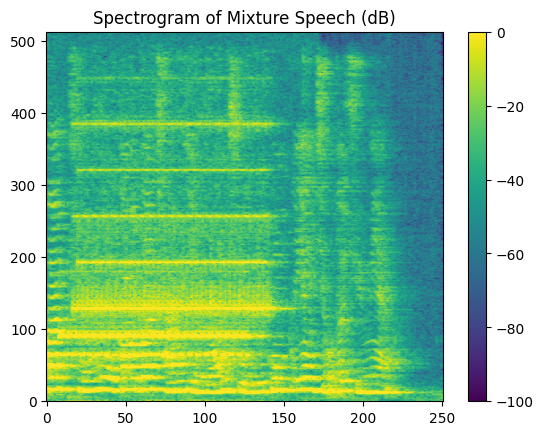

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio

waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

plot_spectrogram(stft_mix[0], "Spectrogram of Mixture Speech (dB)")
evaluate(waveform_mix[0:1], waveform_clean[0:1])
Audio(waveform_mix[0], rate=SAMPLE_RATE)

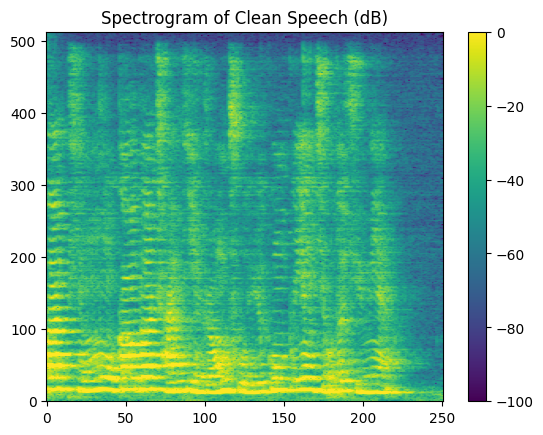

In [ ]:
plot_spectrogram(stft_clean[0], "Spectrogram of Clean Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)

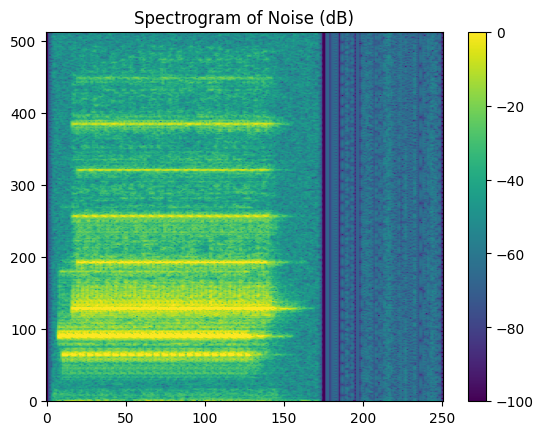

In [ ]:
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)